# Importing Julia packages

In [1]:
using Random
using LightGraphs

using LinearAlgebra
using BenchmarkTools
using PyPlot

## Defining network size and configuration

In [2]:
const N = 1000;       # network size

In [3]:
global omega = rand(N)*2 .- 1;
er_graph = erdos_renyi(N,6000)
global A = adjacency_matrix(er_graph)
global deg = degree(er_graph);

In [4]:
mean(deg)

12.0

In [5]:
using DifferentialEquations

## Declaring functions which define the system of Kuramoto equations

In [6]:
# ==========================================
# convenient form of Kuramoto equation
# ==========================================

function kuramoto(du, u, p, t)
    
    u1 = @view u[1:N]
    du1 = @view du[1:N]
    
    for i in 1:N
        du1[i]  = omega[i] + p * sum(sin.(u[:] .- u[i]))
        end;
    
    end;

In [7]:
# ==========================================
# complex form of Kuramoto equation (sum)
# ==========================================

function kuramoto_complex_sum(du, u, p, t)
    
    u1 = @view u[1:N]
    du1 = @view du[1:N]

    z1 = sum(j -> A[:, j] * exp(u1[j]im), 1:N) ./ deg
    @. du1  = omega + p * deg * imag(z1 * exp((-1im) * u1))
    
    end;

In [8]:
# ==========================================
# CPU multiplication
# ==========================================

function kuramoto_complex_mul(du, u, p, t)
    
    u1 = @view u[1:N]
    du1 = @view du[1:N]

    z1 = Array{Complex{Float64},1}(undef, N)
    mul!(z1, A, exp.((u1)im))
    z1 = z1 ./ deg

    @. du1  = omega + p * deg * imag(z1 * exp((-1im) * u1))
    
    end;

## Setting up initial conditions

In [9]:
# Initial conditions

u0 = rand(N)*6.28
du = similar(u0);

## Performing benchmark tests

In [10]:
# convenient Kuramoto
@benchmark kuramoto(du, u0, 0.0, 0)

BenchmarkTools.Trial: 326 samples with 1 evaluation.
 Range (min … max):  14.708 ms …  19.194 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     14.858 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.351 ms ± 965.956 μs  ┊ GC (mean ± σ):  2.73% ± 5.18%

  ▄██▅▂       ▁                             ▁▁▃                 
  ███████▅█▄▅██▆▄▄▁▁▁▄▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁██████▆▁▄▁▄▄▁▄▄▁▅▄▄ ▆
  14.7 ms       Histogram: log(frequency) by time        18 ms <

 Memory estimate: 15.56 MiB, allocs estimate: 5978.

In [11]:
# complex Kuramoto
@benchmark kuramoto_complex_sum(du, u0, 0.0, 0)

BenchmarkTools.Trial: 1167 samples with 1 evaluation.
 Range (min … max):  3.543 ms … 11.838 ms  ┊ GC (min … max):  0.00% … 41.68%
 Time  (median):     3.632 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   4.277 ms ±  1.099 ms  ┊ GC (mean ± σ):  11.80% ± 14.92%

  █▆                    ▁▅▄                                   
  █████▇▇▆▅▆▄▄▅▆▅▁▅▅▅▄▄▁███▇▁▅▆▄▇▄▅▁▄▄▄▄▁▁▄▁▁▁▁▄▄▁▄▄▁▄▁▅▆▄▄▄ █
  3.54 ms      Histogram: log(frequency) by time     8.42 ms <

 Memory estimate: 22.59 MiB, allocs estimate: 10510.

In [12]:
# complex Kuramoto matrix multiplication
@benchmark kuramoto_complex_mul(du, u0, 0.0, 0)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  73.401 μs …  4.018 ms  ┊ GC (min … max): 0.00% … 95.52%
 Time  (median):     79.495 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   88.084 μs ± 71.931 μs  ┊ GC (mean ± σ):  1.99% ±  2.48%

   ▃▅▆█▇▃▂▂▂▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁ ▁▁  ▁▂                            ▂
  █████████████████████████████▇████▇▇███▇▇▇█▆▆▇█▇▆▆▆▆▅▆▅▅▅▇▅ █
  73.4 μs      Histogram: log(frequency) by time       144 μs <

 Memory estimate: 63.88 KiB, allocs estimate: 17.

# Performing test calculations

In [10]:
# setting up time steps and integration intervals

dt = 0.01 # time step
dts = 0.1 # save time
ti = 0.0
tt = 50.0 
tf = 100.0
nt = Int(div(tt,dts))
nf = Int(div(tf,dts))

tspan = (ti, tf); # time interval

In [14]:
# defining problem for ODE solver
prob = ODEProblem(kuramoto, u0, tspan, 0.0003)

# solving problem using a proper solver
sol = solve(prob, RK4(), dt=dt, saveat=dts, progress=true);
r1 = abs.(mean(exp.(sol*1im),dims=1)[1,:]);

In [15]:
size(sol)

(1000, 1001)

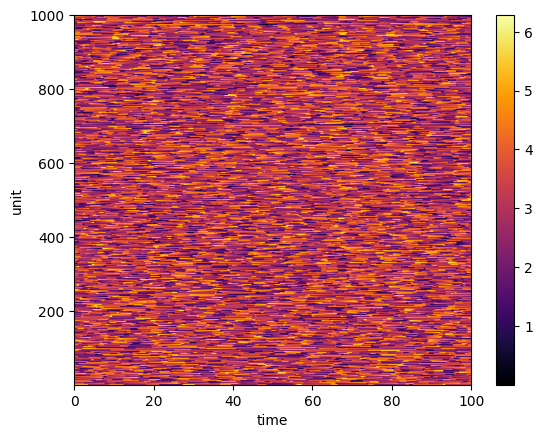

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [16]:
imshow(mod2pi.(sol),cmap="inferno",origin="lower",extent=(0,100,1,1000),aspect="auto")
xlabel("time")
ylabel("unit")
colorbar()
show()

In [17]:
# defining problem for ODE solver
prob = ODEProblem(kuramoto_complex_sum, u0, tspan, 0.0003)

# solving problem using a proper solver
sol = solve(prob, RK4(), dt=dt, saveat=dts, progress=true);
r2 = abs.(mean(exp.(sol*1im),dims=1)[1,:]);

In [18]:
# defining problem for ODE solver
prob = ODEProblem(kuramoto_complex_mul, u0, tspan, 0.0003)

# solving problem using a proper solver
sol = solve(prob, RK4(), dt=dt, saveat=dts, progress=true);
r3 = abs.(mean(exp.(sol*1im),dims=1)[1,:]);

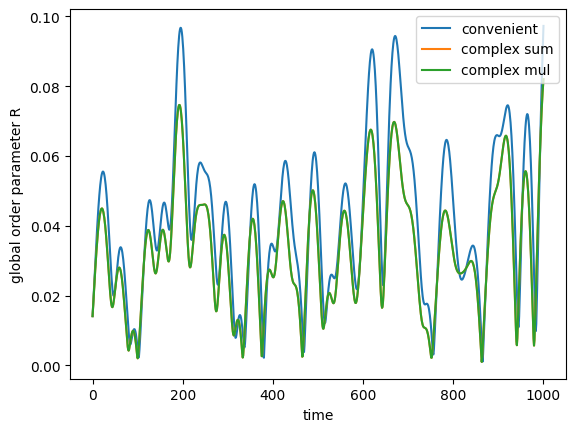

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [19]:
plot(r1,label="convenient")
plot(r2,label="complex sum")
plot(r3,label="complex mul")
ylabel("global order parameter R")
xlabel("time")
legend()
show()

In [20]:
# defining problem for ODE solver
prob = ODEProblem(kuramoto, u0, tspan, 0.0003)

# solving problem using a proper solver
@benchmark solve(prob, RK4(), dt=dt, saveat=dts, progress=true)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 8.011 s (2.65% GC) to evaluate,
 with a memory estimate of 6.41 GiB, over 2520780 allocations.

In [21]:
# defining problem for ODE solver
prob = ODEProblem(kuramoto_complex_sum, u0, tspan, 0.0003)

# solving problem using a proper solver
@benchmark solve(prob, RK4(), dt=dt, saveat=dts, progress=true)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.075 s …   1.143 s  ┊ GC (min … max): 12.70% … 12.45%
 Time  (median):     1.103 s              ┊ GC (median):    12.89%
 Time  (mean ± σ):   1.104 s ± 26.530 ms  ┊ GC (mean ± σ):  12.73% ±  0.17%

  █       █              █         █                      █  
  █▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.08 s         Histogram: frequency by time        1.14 s <

 Memory estimate: 5.46 GiB, allocs estimate: 2598014.

In [22]:
# defining problem for ODE solver
prob = ODEProblem(kuramoto_complex_mul, u0, tspan, 0.0003)

# solving problem using a proper solver
@benchmark solve(prob, RK4(), dt=dt, saveat=dts, progress=true)

BenchmarkTools.Trial: 222 samples with 1 evaluation.
 Range (min … max):  21.578 ms … 28.362 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     21.917 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   22.561 ms ±  1.252 ms  ┊ GC (mean ± σ):  2.95% ± 4.95%

     ▆▄█▃                                                      
  ▅▇▇████▆▄▂▂▃▁▃▃▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▆▅▄▅▃▃▁▃ ▃
  21.6 ms         Histogram: frequency by time          25 ms <

 Memory estimate: 23.32 MiB, allocs estimate: 6243.

# Adaptive Kuramoto model [Zhang et al. PRL, 2016]

In [11]:
# ==========================================
# CPU multiplication
# ==========================================

function kuramoto_adaptive(du, u, p, t)
    
    u1 = @view u[1:N]
    du1 = @view du[1:N]

    z1 = Array{Complex{Float64},1}(undef, N)
    mul!(z1, A, exp.((u1)im))
    z1 = z1 ./ deg

    @. du1  = omega + p * abs(z1) * deg * imag(z1 * exp((-1im) * u1))
    
    end;

In [12]:
# setting up time steps and integration intervals

dt = 0.01 # time step
dts = 0.1 # save time
ti = 0.0
tt = 500.0 
tf = 1000.0
nt = Int(div(tt,dts))
nf = Int(div(tf,dts))

tspan = (ti, tf); # time interval

In [14]:
λ = collect(0:0.2:0.4)

r_fwd = zeros(size(λ)[1])
r_bwd = zeros(size(λ)[1])

println("#####################")
println("Forward transition!")
println("#####################")

for l in 1:size(λ)[1]
    @time begin
    print("λ=")
    println(λ[l])
    # defining problem for ODE solver
    prob = ODEProblem(kuramoto_adaptive, u0, tspan, λ[l])

    # solving problem using a proper solver
    sol = solve(prob, RK4(), dt=dt, saveat=dts, progress=true);
    r_fwd[l] = mean(abs.(mean(exp.(sol*1im),dims=1)[1,:])[nt:nf]);
    
    u0 = mod2pi.(sol[:,nf])
    end
    end;

println("#####################")
println("Backward transition!")
println("#####################")

for l in size(λ)[1]:-1:1
    @time begin
    print("λ=")
    println(λ[l])
    # defining problem for ODE solver
    prob = ODEProblem(kuramoto_adaptive, u0, tspan, λ[l])

    # solving problem using a proper solver
    sol = solve(prob, RK4(), dt=dt, saveat=dts, progress=true);
    r_bwd[l] = mean(abs.(mean(exp.(sol*1im),dims=1)[1,:])[nt:nf]);
    
    u0 = mod2pi.(sol[:,nf])
    end
    end;

#####################
Forward transition!
#####################
λ=0.0
  5.204550 seconds (12.05 M allocations: 1.221 GiB, 11.66% gc time, 86.64% compilation time)
λ=0.2
  1.484875 seconds (232.40 k allocations: 1.079 GiB, 15.75% gc time)
λ=0.4
  2.312491 seconds (493.34 k allocations: 1.917 GiB, 3.60% gc time)
#####################
Backward transition!
#####################
λ=0.4
  2.657830 seconds (492.43 k allocations: 1.914 GiB, 16.30% gc time)
λ=0.2
  1.290378 seconds (262.49 k allocations: 1.176 GiB, 4.62% gc time)
λ=0.0
  0.508320 seconds (60.94 k allocations: 541.849 MiB, 35.02% gc time)


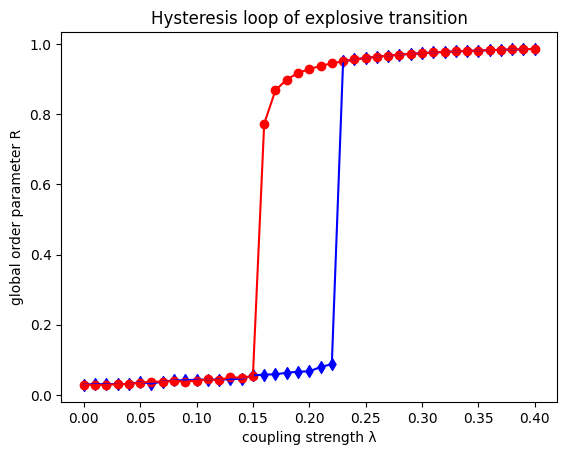

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [28]:
title("Hysteresis loop of explosive transition")
plot(λ,r_fwd,c="blue")
scatter(λ,r_fwd,c="blue",marker="d")
plot(λ,r_bwd,c="red")
scatter(λ,r_bwd,c="red")
ylabel("global order parameter R")
xlabel("coupling strength λ")

#savefig("/Users/nikitafrolov/Dropbox/2022. Resourse_EI/fig1.eps")
show()

In [40]:
using DelimitedFiles

In [41]:
writedlm("/Users/nikitafrolov/Dropbox/2022. Resourse_EI/data.dat",r_fwd)

# Failure using a fixed time step integration

In [29]:
omega = rand(N)*2 .+ 100;

In [30]:
λ = collect(0:0.01:0.4)

r_fwd2 = zeros(size(λ)[1])

println("#####################")
println("Forward transition!")
println("#####################")

for l in 1:size(λ)[1]
    print("λ=")
    println(λ[l])
    # defining problem for ODE solver
    prob = ODEProblem(kuramoto_adaptive, u0, tspan, λ[l])

    # solving problem using a proper solver
    sol = solve(prob, RK4(), dt=dt, saveat=dts, progress=true);
    r_fwd2[l] = mean(abs.(mean(exp.(sol*1im),dims=1)[1,:])[nt:nf]);
    
    u0 = mod2pi.(sol[:,nf])
    end;

#####################
Forward transition!
#####################
λ=0.0
λ=0.01
λ=0.02
λ=0.03
λ=0.04
λ=0.05
λ=0.06
λ=0.07
λ=0.08
λ=0.09
λ=0.1
λ=0.11
λ=0.12
λ=0.13
λ=0.14
λ=0.15
λ=0.16
λ=0.17
λ=0.18
λ=0.19
λ=0.2
λ=0.21
λ=0.22
λ=0.23
λ=0.24
λ=0.25
λ=0.26
λ=0.27
λ=0.28
λ=0.29
λ=0.3
λ=0.31
λ=0.32
λ=0.33
λ=0.34
λ=0.35
λ=0.36
λ=0.37
λ=0.38
λ=0.39
λ=0.4


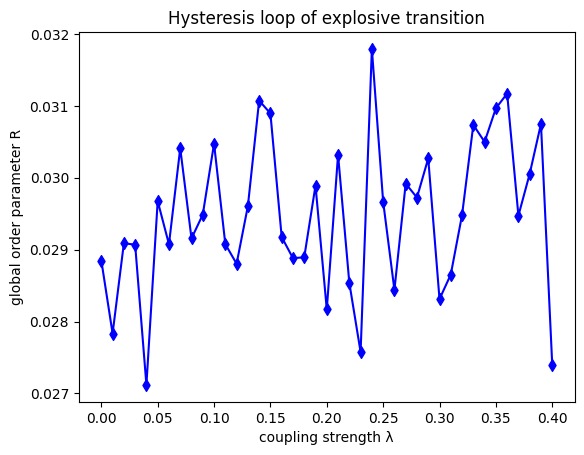

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [32]:
title("Hysteresis loop of explosive transition")
plot(λ,r_fwd2,c="blue")
scatter(λ,r_fwd2,c="blue",marker="d")
ylabel("global order parameter R")
xlabel("coupling strength λ")
show()

In [33]:
λ = collect(0:0.01:0.4)

r_fwd2 = zeros(size(λ)[1])

println("#####################")
println("Forward transition!")
println("#####################")

for l in 1:size(λ)[1]
    print("λ=")
    println(λ[l])
    # defining problem for ODE solver
    prob = ODEProblem(kuramoto_adaptive, u0, tspan, λ[l])

    # solving problem using a proper solver
    sol = solve(prob, RK4(), reltol=1e-6, saveat=dts, progress=true);
    r_fwd2[l] = mean(abs.(mean(exp.(sol*1im),dims=1)[1,:])[nt:nf]);
    
    u0 = mod2pi.(sol[:,nf])
    end;

#####################
Forward transition!
#####################
λ=0.0
λ=0.01
λ=0.02
λ=0.03
λ=0.04
λ=0.05
λ=0.06
λ=0.07
λ=0.08
λ=0.09
λ=0.1
λ=0.11
λ=0.12
λ=0.13
λ=0.14
λ=0.15
λ=0.16
λ=0.17
λ=0.18
λ=0.19
λ=0.2
λ=0.21
λ=0.22
λ=0.23
λ=0.24
λ=0.25
λ=0.26
λ=0.27
λ=0.28
λ=0.29
λ=0.3
λ=0.31
λ=0.32
λ=0.33
λ=0.34
λ=0.35
λ=0.36
λ=0.37
λ=0.38
λ=0.39
λ=0.4


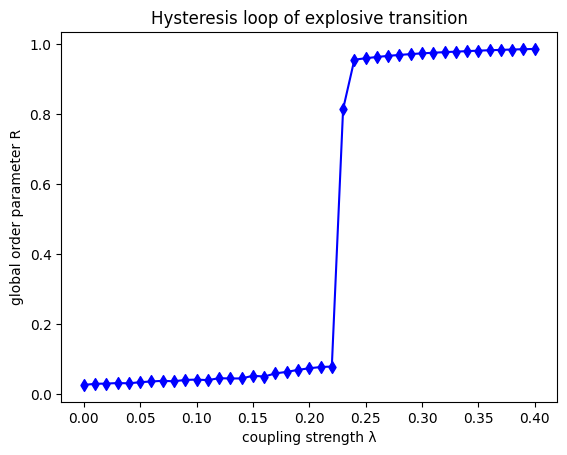

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [34]:
title("Hysteresis loop of explosive transition")
plot(λ,r_fwd2,c="blue")
scatter(λ,r_fwd2,c="blue",marker="d")
ylabel("global order parameter R")
xlabel("coupling strength λ")
show()

In [5]:
using Random
rand(5,1)

5×1 Matrix{Float64}:
 0.6930212463124392
 0.570490002624154
 0.5132259248378643
 0.21669830293605608
 0.5611132828812728

In [56]:
x=rand(10,1)

10×1 Matrix{Float64}:
 0.7833386921710528
 0.489441393828693
 0.4163685336569354
 0.04853356982072121
 0.5906304245785741
 0.011653355080131877
 0.6597209259175822
 0.6743690860741909
 0.12681516622497502
 0.982330769017814

In [57]:
y=rand(10,1)

10×1 Matrix{Float64}:
 0.24247365552504507
 0.8656342827815173
 0.7873880232452686
 0.9585494801008978
 0.3933975678998327
 0.9477743666519987
 0.3687037639125472
 0.6687240267852343
 0.000610049928596812
 0.593080323925574

In [58]:
xx=zeros(10,1)
yy=zeros(10,1)
for i in 1:length(x)
    xx[i]=min(x[i],y[i])
    yy[i]=max(x[i],y[i])
end

In [59]:
xx

10×1 Matrix{Float64}:
 0.24247365552504507
 0.489441393828693
 0.4163685336569354
 0.04853356982072121
 0.3933975678998327
 0.011653355080131877
 0.3687037639125472
 0.6687240267852343
 0.000610049928596812
 0.593080323925574

In [60]:
yy

10×1 Matrix{Float64}:
 0.7833386921710528
 0.8656342827815173
 0.7873880232452686
 0.9585494801008978
 0.5906304245785741
 0.9477743666519987
 0.6597209259175822
 0.6743690860741909
 0.12681516622497502
 0.982330769017814

LoadError: MethodError: no method matching getindex(::typeof(maximum), ::Matrix{Float64}, ::Matrix{Float64})

In [55]:
yy

10×1 Matrix{Float64}:
 0.6125422859467891
 0.9166164637972716
 0.790689061814428
 0.26879244135367975
 0.643357428818017
 0.43622129982230984
 0.3736676684776359
 0.6575309232766924
 0.7375672987375612
 0.35331741713083464

In [64]:
size(xx)[1]

10